# Image Segmentation by unsupervised Learning

## import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm, tqdm_notebook
import random
import os

## load data

In [2]:
from google.colab import drive 
drive.mount('/content/drive/')

directory_data  = './drive/MyDrive/Machine_Learning/'
filename_data   = 'assignment_10_data.npz'

data            = np.load(os.path.join(directory_data, filename_data))
image_clean     = torch.from_numpy(data['real_images']).float()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## custom data loader for the PyTorch framework

In [3]:
class dataset (Dataset):
    def  __init__(self, data, std_noise):

        noise = torch.randn(data.size()) * std_noise

        self.clean  = data
        self.noisy  = data + noise

    def __getitem__(self, index):

        clean   = self.clean[index]
        noisy   = self.noisy[index]
        
        clean = torch.FloatTensor(clean).unsqueeze(dim=0)
        noisy = torch.FloatTensor(noisy).unsqueeze(dim=0)

        return (clean, noisy)
  
    def __len__(self):
        
        return self.clean.shape[0]

In [4]:
image_train = image_clean[::2]
image_test  = image_clean[1::2]

dataset_train   = dataset(image_train, 0.5)
dataset_test    = dataset(image_test, 0.5)

## hyper-parameters

In [5]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

number_epoch    = 20
size_minibatch  = 50
learning_rate   = 0.1
weight_decay    = 0.0001
weight_regular  = 0.0001

## construct datasets and dataloaders for training and testing

In [6]:
dataloader_train            = DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True)
dataloader_test             = DataLoader(dataset_test, batch_size=size_minibatch, shuffle=False, drop_last=True)

## shape of the data when using the data loader

In [7]:
(image_train, label_train)  = dataset_train[0]
(image_test, label_test)    = dataset_test[0]
print('*******************************************************************')
print('shape of the image in the training dataset:', image_train.shape)
print('shape of the label in the training dataset:', label_train.shape)
print('*******************************************************************')
print('shape of the image in the testing dataset:', image_test.shape)
print('shape of the label in the testing dataset:', label_test.shape)
print('*******************************************************************')

*******************************************************************
shape of the image in the training dataset: torch.Size([1, 32, 32])
shape of the label in the training dataset: torch.Size([1, 32, 32])
*******************************************************************
shape of the image in the testing dataset: torch.Size([1, 32, 32])
shape of the label in the testing dataset: torch.Size([1, 32, 32])
*******************************************************************


## class for the neural network 

## build network

In [8]:
class DownConv(nn.Module):
    def __init__(self, in_channels = 1, out_channels = 32, init_filters = 32, n_filters_per_depth=2,
                 kernel_size=3, stride=1, padding=1, bias=True, groups=1):
        """
        A helper Module that performs either 2 or 3 convolutions and 1 MaxPool.
        A ReLU activation follows each convolution.
        """
        super(DownConv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.init_filters = init_filters 
        self.n_filters_per_depth = n_filters_per_depth
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.bias = bias
        self.groups = groups
        
        ins = self.in_channels
        outs = self.out_channels
        
        self.conv1 = nn.Conv2d(in_channels=ins, out_channels=outs, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=self.bias, groups = self.groups)
        self.conv2 = nn.Conv2d(in_channels=outs, out_channels=outs, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=self.bias, groups = self.groups)
        if(self.n_filters_per_depth==3):
            self.conv3 = nn.Conv2d(in_channels=outs, out_channels=outs, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=self.bias, groups = self.groups)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)    
    
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        if(self.n_filters_per_depth==3):
            x = F.relu(self.conv3(x))
        x = self.pool(x)
        return x
    
    
class UpConv(nn.Module):
    def __init__(self, in_channels = 1, out_channels = 32, init_filters = 32, n_filters_per_depth=2, 
                 kernel_size=3, stride=1, padding=1, bias=True, groups=1):
        """
        A helper Module that performs either 2 or 3 convolutions and 1 UpConvolution.
        A ReLU activation follows each convolution.
        """
        super(UpConv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.init_filters = init_filters 
        self.n_filters_per_depth = n_filters_per_depth
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.bias = bias
        self.groups = groups
        
        ins = self.in_channels
        outs = self.out_channels
        
        self.conv1 = nn.Conv2d(in_channels=ins, out_channels=outs, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=self.bias, groups = self.groups)
        self.conv2 = nn.Conv2d(in_channels=outs, out_channels=outs, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=self.bias, groups = self.groups)
        if(self.n_filters_per_depth==3):
            self.conv3 = nn.Conv2d(in_channels=outs, out_channels=outs, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=self.bias, groups = self.groups)
        self.convtranspose = nn.ConvTranspose2d(in_channels=outs, out_channels=outs, kernel_size=2, stride=2)    
    
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        if(self.n_filters_per_depth==3):
            x = F.relu(self.conv3(x))
        x = self.convtranspose(x)
        return x

In [9]:
class Network(nn.Module): 

	def __init__(self, in_channel=1, out_channel=1, dim_feature=256):
        
		super(Network, self).__init__()

		self.in_channel 	= in_channel
		self.out_channel	= out_channel
		self.dim_feature	= dim_feature
		
		self.conv_encode1	= nn.Conv2d(in_channel , dim_feature * 1, kernel_size=3, stride=2, padding=1, bias=True)
		self.conv_encode2	= nn.Conv2d(dim_feature * 1, dim_feature * 2, kernel_size=3, stride=2, padding=1, bias=True)

		self.conv_middle	= nn.Conv2d(dim_feature * 2, dim_feature * 4, kernel_size=3, stride=1, padding=1, bias=True)

		self.conv_decode2 	= nn.Conv2d(dim_feature * 4, dim_feature * 2, kernel_size=3, stride=1, padding=1, bias=True)
		self.conv_decode1 	= nn.Conv2d(dim_feature * 2, dim_feature * 1, kernel_size=3, stride=1, padding=1, bias=True)
		self.conv_out 		= nn.Conv2d(dim_feature * 1, out_channel,	kernel_size=1, stride=1, padding=0, bias=True)

		self.ebn1			= nn.BatchNorm2d(dim_feature * 1)
		self.ebn2			= nn.BatchNorm2d(dim_feature * 2)
		self.mbn		 	= nn.BatchNorm2d(dim_feature * 4)
		self.dbn2			= nn.BatchNorm2d(dim_feature * 2)
		self.dbn1			= nn.BatchNorm2d(dim_feature * 1)

		self.activation		= nn.ReLU(inplace=True)
		self.activation_out	= nn.Sigmoid()

		# *********************************************************************
		# forward propagation
		# *********************************************************************
	def forward(self, x):

		x1  = self.conv_encode1(x)
		eb1 = self.ebn1(x1)
		e1  = self.activation(eb1)
		
		x2  = self.conv_encode2(e1)
		eb2 = self.ebn2(x2)
		e2  = self.activation(eb2)
		
		m   = self.conv_middle(e2)
		mb  = self.mbn(m)
		c   = self.activation(mb)

		y2  = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)(c)
		y2  = self.conv_decode2(y2) 
		db2 = self.dbn2(y2)
		d2  = self.activation(db2)

		y1  = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)(d2)
		y1  = self.conv_decode1(y1) 
		db1 = self.dbn1(y1)
		d1  = self.activation(db1)
		
		y1  = self.conv_out(d1)
		y = self.activation_out(y1)

		return y

In [10]:
# encoder = SegNet().to(device)

# from torchsummary import summary
# summary(encoder, (1, 32, 32))

In [11]:
model       = Network().to(device)
optimizer   = torch.optim.Adam(model.parameters(), lr=0.01)

## compute the prediction

In [12]:
def compute_prediction(model, input):
    # ==================================================
    # fill up the blank
    #

    prediction = model(input)
    
    # 
    # ==================================================

    return prediction

In [13]:
def compute_estimate(input, prediction):

    number_phase = 2 # bi-partitioning
    (batch, channel, height, width) = input.size()

    estimate = torch.zeros(number_phase, batch, channel).to(device)
    
    prediction_inside   = prediction
    prediction_outside  = 1 - prediction

    # ==================================================
    # fill up the blank for the estimate of the inside of segmenting region
    #
    inside = input * prediction_inside
    #print(inside.shape)
    inside = inside.sum(axis=3).sum(axis=2)
    inside = inside / prediction_inside.sum(axis=3).sum(axis=2)
    estimate[0] = inside
    # 
    # ==================================================
    
    # ==================================================
    # fill up the blank for the estimate of the outside of segmenting region
    #
    outside = input * prediction_outside
    outside = outside.sum(axis=3).sum(axis=2)
    outside = outside / prediction_outside.sum(axis=3).sum(axis=2)
    estimate[1] = outside  
    # 
    # ==================================================
    
    return estimate

In [14]:
def compute_loss_data(input, prediction):

    (batch, channel, height, width) = input.size()
    estimate = compute_estimate(input, prediction)

    prediction_inside   = prediction
    prediction_outside  = 1 - prediction

    estimate0           = torch.unsqueeze(torch.unsqueeze(estimate[0], dim=-1), dim=-1) 
    estimate1           = torch.unsqueeze(torch.unsqueeze(estimate[1], dim=-1), dim=-1) 

    residual_inside     = torch.square(input - estimate0)
    residual_outside    = torch.square(input - estimate1)

    # print("shape of residual_inside : ", residual_inside.shape)
    # print("shape of residual_outside : ", residual_outside.shape)
    
    # ==================================================
    # fill up the blank for the data fidelity of the inside of segmenting region
    #
    fidelity_inside = (residual_inside * prediction_inside).sum()
    # 
    # ==================================================
    
    # ==================================================
    # fill up the blank for the data fidelity of the inside of segmenting region
    #
    fidelity_outside = (residual_outside * prediction_outside).sum()
    # 
    # ==================================================

    fidelity = fidelity_inside + fidelity_outside
    loss_data       = fidelity / (batch * channel * height * width)
    loss_data_value = loss_data.item()

    return loss_data, loss_data_value

In [15]:
def compute_regularization(prediction):

    (batch, channel, height, width) = prediction.size()
   
    gradient_height = torch.abs(prediction[:, :, 1:, :] - prediction[:, :, :- 1, :]).sum()
    gradient_width  = torch.abs(prediction[:, :, :, 1:] - prediction[:, :, :, :-1]).sum()

    loss_regularization         = (gradient_height + gradient_width) / (batch * channel * height * width)
    loss_regularization_value   = loss_regularization.item()
    
    return loss_regularization, loss_regularization_value

## compute the loss

In [16]:
def compute_loss(input, prediction, alpha):

    (loss_data, _)              = compute_loss_data(input, prediction)
    (loss_regularization, _)    = compute_regularization(prediction)

    # ==================================================
    # fill up the blank for the loss that consists of the data fidelity and the regularization with a weight
    #
    loss        = loss_data + alpha * loss_regularization
    # 
    # ==================================================

    loss_value  = loss.item()

    return loss, loss_value

## compute the accuracy

In [17]:
def compute_accuracy(prediction, label):
    
    prediction  = prediction.squeeze(axis=1)
    label       = label.squeeze(axis=1)

    prediction_binary   = (prediction >= 0.5).cpu().numpy()
    label               = label.bool().cpu().numpy()
    
    region_intersection = prediction_binary & label
    region_union        = prediction_binary | label

    area_intersection   = region_intersection.sum(axis=1).sum(axis=1).astype(float)
    area_union          = region_union.sum(axis=1).sum(axis=1).astype(float)

    eps         = np.finfo(float).eps
    correct     = area_intersection / (area_union + eps)
    accuracy    = correct.mean() * 100.0
    
    return accuracy

## variables for the learning curve

In [18]:
loss_mean_train     = np.zeros(number_epoch)
loss_std_train      = np.zeros(number_epoch)
accuracy_mean_train = np.zeros(number_epoch)
accuracy_std_train  = np.zeros(number_epoch)

loss_mean_test      = np.zeros(number_epoch)
loss_std_test       = np.zeros(number_epoch)
accuracy_mean_test  = np.zeros(number_epoch)
accuracy_std_test   = np.zeros(number_epoch)

## train

In [19]:
def train(model, dataloader):

    loss_epoch      = []
    accuracy_epoch  = []

    model.train()

    for index_batch, (clean, noisy) in enumerate(dataloader):

        clean = clean.to(device)
        noisy = noisy.to(device)
        
        prediction          = compute_prediction(model, noisy)
        loss, loss_value    = compute_loss(noisy, prediction, weight_regular)
        accuracy1           = compute_accuracy(prediction, clean)
        accuracy2           = compute_accuracy(1 - prediction, clean)
        accuracy            = np.maximum(accuracy1, accuracy2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch.append(loss_value)
        accuracy_epoch.append(accuracy)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    accuracy_mean_epoch = np.mean(accuracy_epoch)
    accuracy_std_epoch  = np.std(accuracy_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    accuracy    = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch}

    return (loss, accuracy)    


## test

In [20]:
def test(model, dataloader):

    loss_epoch      = []
    accuracy_epoch  = []

    model.eval()

    for index_batch, (clean, noisy) in enumerate(dataloader):

        clean = clean.to(device)
        noisy = noisy.to(device)
        
        prediction          = compute_prediction(model, noisy)
        loss, loss_value    = compute_loss(noisy, prediction, weight_regular)
        accuracy1           = compute_accuracy(prediction, clean)
        accuracy2           = compute_accuracy(1 - prediction, clean)
        accuracy            = np.maximum(accuracy1, accuracy2)

        loss_epoch.append(loss_value)
        accuracy_epoch.append(accuracy)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    accuracy_mean_epoch = np.mean(accuracy_epoch)
    accuracy_std_epoch  = np.std(accuracy_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    accuracy    = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch}

    return (loss, accuracy)    

## train and test

In [21]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm_notebook(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_train, accuracy_train) = train(model, dataloader_train)

    loss_mean_train[i]      = loss_train['mean']
    loss_std_train[i]       = loss_train['std']

    accuracy_mean_train[i]  = accuracy_train['mean']
    accuracy_std_train[i]   = accuracy_train['std']

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    (loss_test, accuracy_test) = test(model, dataloader_test)

    loss_mean_test[i]      = loss_test['mean']
    loss_std_test[i]       = loss_test['std']

    accuracy_mean_test[i]  = accuracy_test['mean']
    accuracy_std_test[i]   = accuracy_test['std']

    print(f"epoch : {i}")
    print(f"\ttrain loss : {loss_train['mean']}, train acc : {accuracy_train['mean']}")
    print(f"\ttest loss  : {loss_test['mean']},  test acc  : {accuracy_test['mean']}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

epoch : 0
	train loss : 0.28066721905109493, train acc : 74.50160472051694
	test loss  : 0.25872605761816336,  test acc  : 87.3818137176133
epoch : 1
	train loss : 0.2590232283570046, train acc : 88.61656376029762
	test loss  : 0.2580168309599854,  test acc  : 88.52821827555758
epoch : 2
	train loss : 0.25433263737101885, train acc : 92.96063628207112
	test loss  : 0.25134418939435205,  test acc  : 95.25547523123207
epoch : 3
	train loss : 0.2529063186673231, train acc : 94.62065614307856
	test loss  : 0.2524478099373884,  test acc  : 94.34341627651742
epoch : 4
	train loss : 0.25113309157449143, train acc : 96.85697788081559
	test loss  : 0.2499302209809769,  test acc  : 97.41060808195851
epoch : 5
	train loss : 0.25059833152349603, train acc : 97.7142542608388
	test loss  : 0.2501471527787142,  test acc  : 97.30821153772449
epoch : 6
	train loss : 0.25052998682787253, train acc : 97.77463426510808
	test loss  : 0.24970857729745466,  test acc  : 97.94466723031196
epoch : 7
	train loss

# functions for visualizing the results 

---

## plot curve

In [22]:
def plot_data_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [23]:
def plot_data_tensor_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    data = data.detach().cpu().squeeze(axis=1)

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [24]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title):

    plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

In [25]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [26]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [27]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [28]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [29]:
def function_result_01():

    print('[plot examples of the training noisy images]')
    print('') 

    nRow = 8
    nCol = 6

    number_data = len(dataset_train)
    step        = np.floor(number_data / (nRow * nCol))
    index_data  = np.arange(0, number_data, step)
    index_plot  = np.arange(0, nRow * nCol)

    _, data     = dataset_train[index_data]
    data        = data[0]
    
    plot_data_grid(data, index_plot, nRow, nCol)

In [30]:
def function_result_02():

    print('[plot examples of the training ground truth images]')
    print('') 
    
    nRow = 8
    nCol = 6

    number_data = len(dataset_train)
    step        = np.floor(number_data / (nRow * nCol))
    index_data  = np.arange(0, number_data, step)
    index_plot  = np.arange(0, nRow * nCol)

    data, _     = dataset_train[index_data]
    data        = data[0]
    
    plot_data_grid(data, index_plot, nRow, nCol)

In [31]:
def function_result_03():

    print('[plot examples of the training segmentation results]')
    print('') 

    nRow = 8
    nCol = 6

    number_data = len(dataset_train)
    step        = np.floor(number_data / (nRow * nCol))
    index_data  = np.arange(0, number_data, step)
    index_plot  = np.arange(0, nRow * nCol)

    _, data     = dataset_train[index_data] 
    data        = data[0].unsqueeze(dim=1).to(device)
    prediction  = compute_prediction(model, data)
    
    plot_data_tensor_grid(prediction, index_plot, nRow, nCol)

In [32]:
def function_result_04():

    print('[plot examples of the testing noisy images]')
    print('') 
    
    nRow = 8
    nCol = 6

    number_data = len(dataset_test)
    step        = np.floor(number_data / (nRow * nCol))
    index_data  = np.arange(0, number_data, step)
    index_plot  = np.arange(0, nRow * nCol)

    _, data     = dataset_test[index_data]
    data        = data[0]
    
    plot_data_grid(data, index_plot, nRow, nCol)

In [33]:
def function_result_05():

    print('[plot examples of the testing ground truth images]')
    print('') 

    nRow = 8
    nCol = 6

    number_data = len(dataset_test)
    step        = np.floor(number_data / (nRow * nCol))
    index_data  = np.arange(0, number_data, step)
    index_plot  = np.arange(0, nRow * nCol)
   
    data, _     = dataset_test[index_data]
    data        = data[0]
    
    plot_data_grid(data, index_plot, nRow, nCol)

In [34]:
def function_result_06():

    print('[plot examples of the testing segmentation results]')
    print('') 

    nRow = 8
    nCol = 6

    number_data = len(dataset_test)
    step        = np.floor(number_data / (nRow * nCol))
    index_data  = np.arange(0, number_data, step)
    index_plot  = np.arange(0, nRow * nCol)

    _, data     = dataset_test[index_data]
    data        = data[0].unsqueeze(dim=1).to(device)
    prediction  = compute_prediction(model, data)
    
    plot_data_tensor_grid(prediction, index_plot, nRow, nCol)

In [35]:
def function_result_07():

    print('[plot the training loss]')
    print('') 

    plot_curve_error(loss_mean_train, loss_std_train, 'epoch', 'loss', 'loss (training)')

In [36]:
def function_result_08():

    print('[plot the training accuracy]')
    print('') 
    
    plot_curve_error(accuracy_mean_train, accuracy_std_train, 'epoch', 'accuracy', 'accuracy (training)')

In [37]:
def function_result_09():
    
    print('[plot the testing loss]')
    print('') 
    
    plot_curve_error(loss_mean_test, loss_std_test, 'epoch', 'loss', 'loss (testing)')

In [38]:
def function_result_10():
    
    print('[plot the testing accuracy]') 
    print('') 
    
    plot_curve_error(accuracy_mean_test, accuracy_std_test, 'epoch', 'accuracy', 'accuracy (testing)')

In [39]:
def function_result_11():
    
    print('[print the training loss at the last 10 epochs]')
    print('') 

    data_last   = get_data_last(loss_mean_train, -10)
    index       = np.arange(0, 10)
    
    print_curve(data_last, index)

In [40]:
def function_result_12():
    
    print('[print the training accuracy at the last 10 epochs]')
    print('') 
    
    data_last   = get_data_last(accuracy_mean_train, -10)
    index       = np.arange(0, 10)
    
    print_curve(data_last, index)

In [41]:
def function_result_13():
    
    print('[print the testing loss at the last 10 epochs]')
    print('') 
    
    data_last   = get_data_last(loss_mean_test, -10)
    index       = np.arange(0, 10)
    
    print_curve(data_last, index)

In [42]:
def function_result_14():
    
    print('[print the testing accuracy at the last 10 epochs]')
    print('') 
    
    data_last   = get_data_last(accuracy_mean_test, -10)
    index       = np.arange(0, 10)
    
    print_curve(data_last, index)

In [43]:
def function_result_15():
    
    print('[print the best training accuracy within the last 10 epochs]')
    print('') 

    value = get_max_last_range(accuracy_mean_train, -10)
    print('best training accuracy = %12.10f' % (value))

In [44]:
def function_result_16():
    
    print('[print the best testing accuracy within the last 10 epochs]')
    print('') 
    
    value = get_max_last_range(accuracy_mean_test, -10)
    print('best testing accuracy = %12.10f' % (value))

---

# RESULTS

---


################################################################################
#
# RESULT # 01
#
################################################################################

[plot examples of the training noisy images]



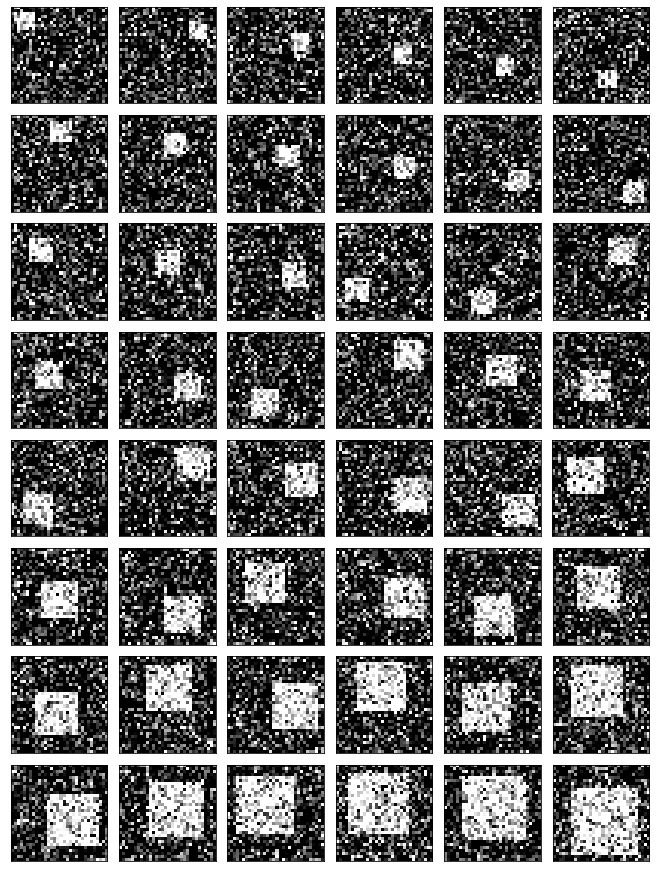


################################################################################
#
# RESULT # 02
#
################################################################################

[plot examples of the training ground truth images]



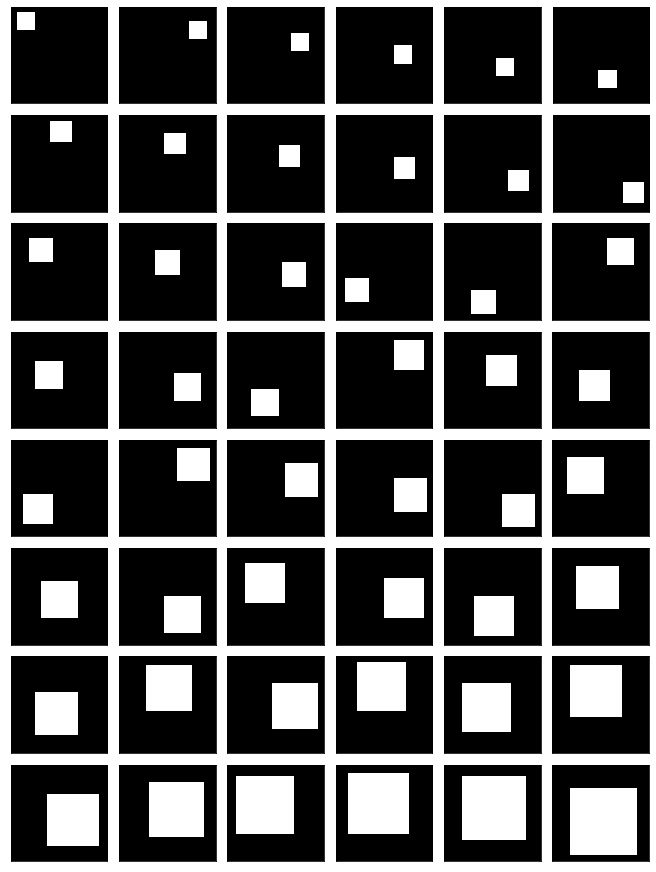


################################################################################
#
# RESULT # 03
#
################################################################################

[plot examples of the training segmentation results]



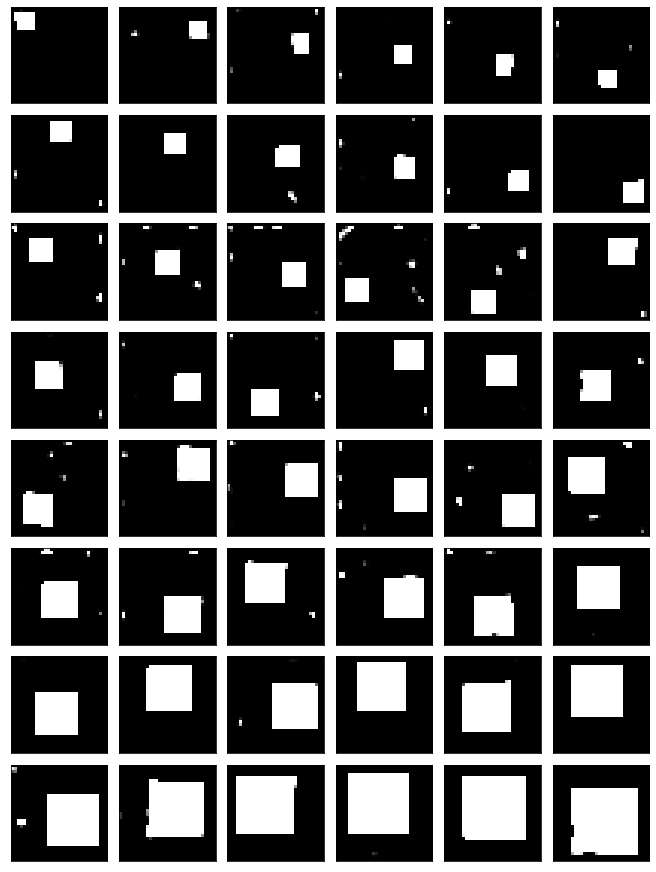


################################################################################
#
# RESULT # 04
#
################################################################################

[plot examples of the testing noisy images]



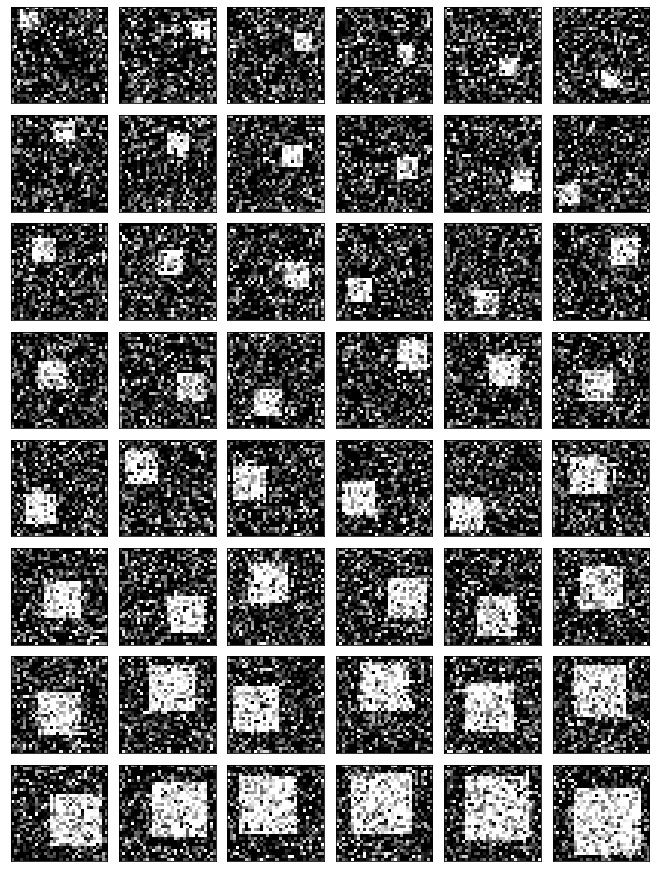


################################################################################
#
# RESULT # 05
#
################################################################################

[plot examples of the testing ground truth images]



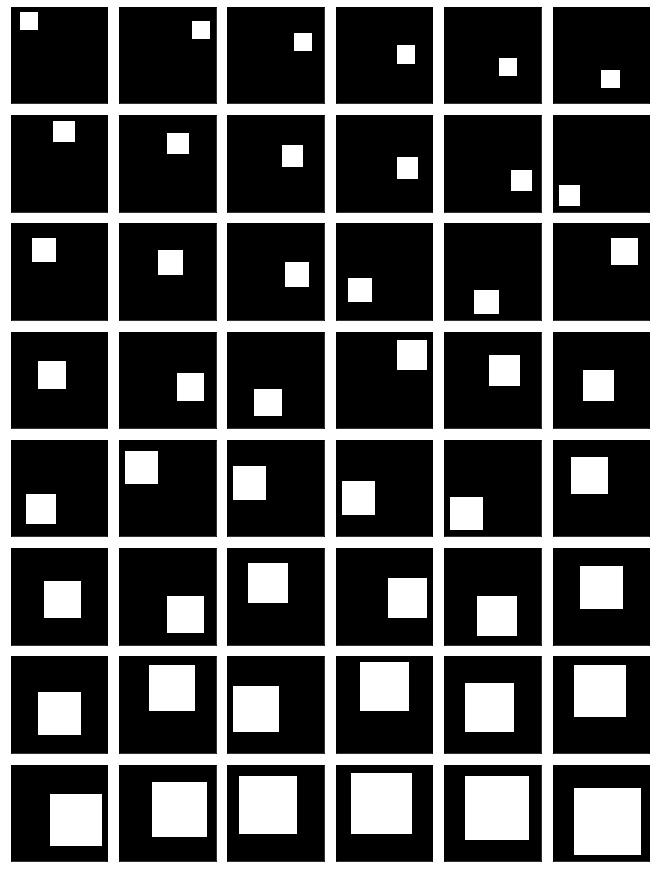


################################################################################
#
# RESULT # 06
#
################################################################################

[plot examples of the testing segmentation results]



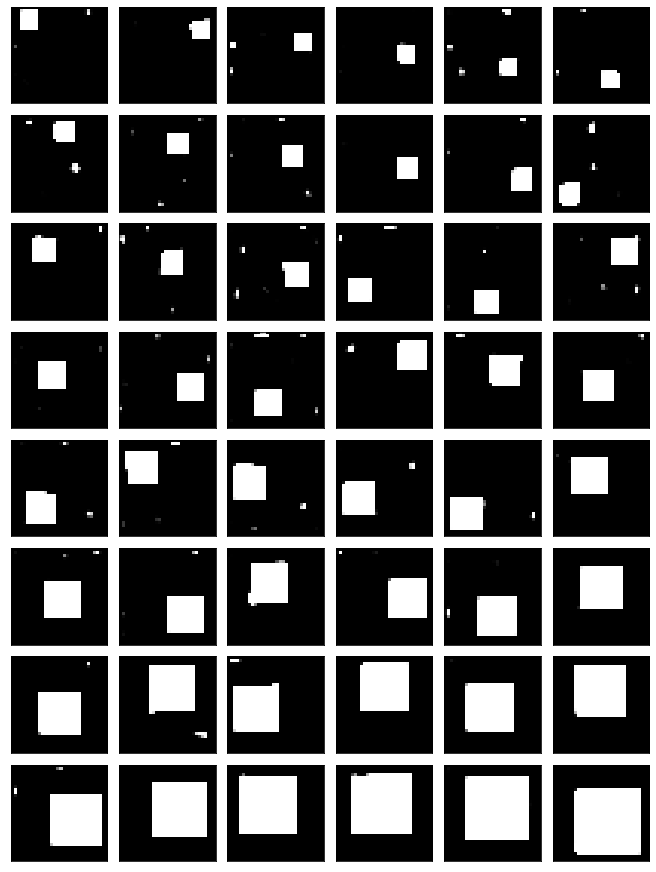


################################################################################
#
# RESULT # 07
#
################################################################################

[plot the training loss]



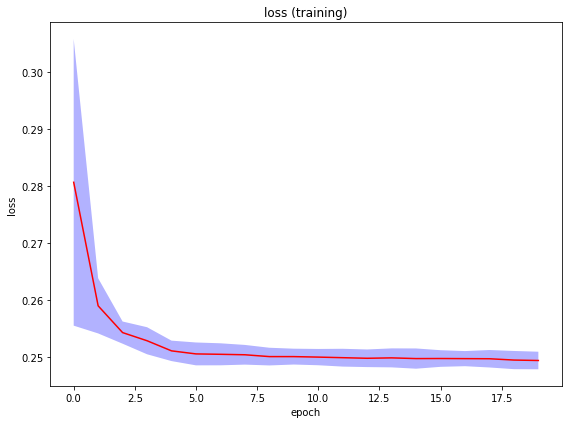


################################################################################
#
# RESULT # 08
#
################################################################################

[plot the training accuracy]



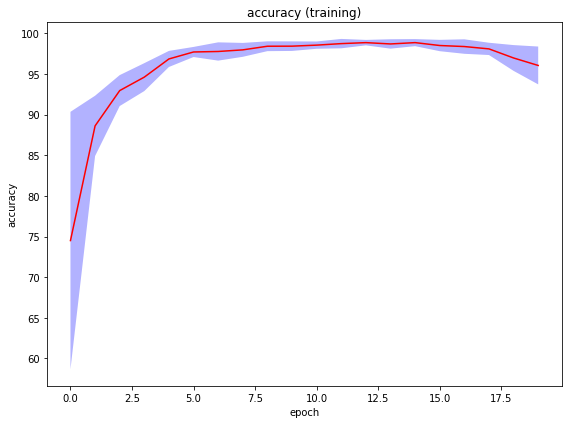


################################################################################
#
# RESULT # 09
#
################################################################################

[plot the testing loss]



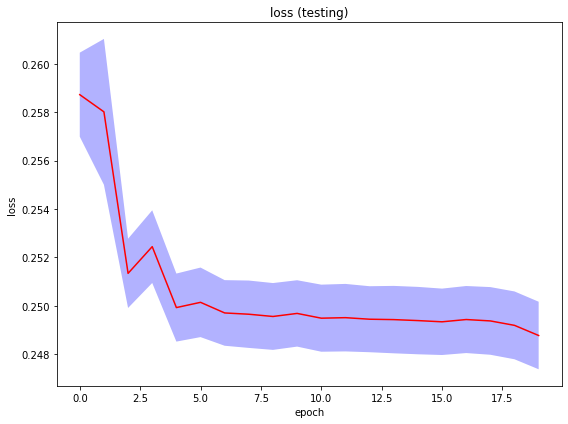


################################################################################
#
# RESULT # 10
#
################################################################################

[plot the testing accuracy]



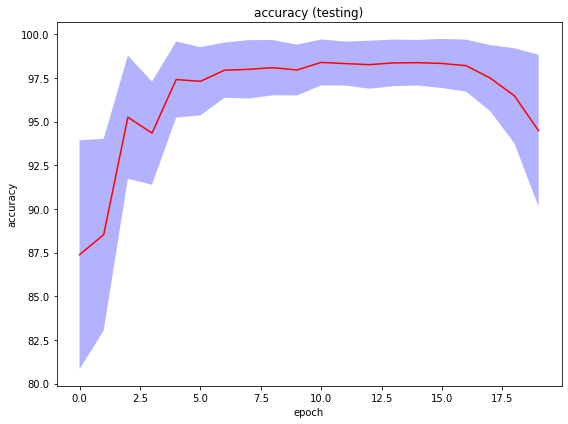


################################################################################
#
# RESULT # 11
#
################################################################################

[print the training loss at the last 10 epochs]

index =  0, value = 0.2500395761
index =  1, value = 0.2499367394
index =  2, value = 0.2498334088
index =  3, value = 0.2499039703
index =  4, value = 0.2497801275
index =  5, value = 0.2497914503
index =  6, value = 0.2497709660
index =  7, value = 0.2497507951
index =  8, value = 0.2495219011
index =  9, value = 0.2494446757

################################################################################
#
# RESULT # 12
#
################################################################################

[print the training accuracy at the last 10 epochs]

index =  0, value = 98.5567703129
index =  1, value = 98.7428843408
index =  2, value = 98.8642208694
index =  3, value = 98.7018695493
index =  4, value = 98.8651145140
index =  5, value = 98.5090207478


In [45]:
number_result = 16

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)